In [126]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists
import opendatasets as od
import shutil
import wbgapi as wb

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az

import plotly.express as px

import requests
from io import BytesIO

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'us_2024')))
rng = np.random.default_rng(SEED)

# Load Data

In [194]:
df_macro = pd.read_csv("../Data/clean/macro.csv").iloc[:,1:]
df_2party = pd.read_csv("../Data/raw/election_two_party.csv")
df_candidate = pd.read_csv("../Data/raw/candidate_id.csv")

In [195]:
df = df_2party

In [196]:
age = pd.concat([df['inc_age'],df['chal_age']])
df[['inc_age','chal_age']] = (df[['inc_age','chal_age']] - age.mean())/age.std()

In [197]:
df = df.merge(df_macro)
df = df.merge(df_candidate, left_on="inc_candidate_id", right_on="candidate_id", suffixes=("_i","_c"))
df = df.merge(df_candidate, left_on="chal_candidate_id", right_on="candidate_id", suffixes=("_i","_c"))

# Model

In [300]:
df_train = df.iloc[:-3,:]
df_test = df.iloc[-3:,:]

with pm.Model() as model:
    # Priors with Cauchy distributions
    incumb_p_advantage = pm.Cauchy('incumb_p_advantage', alpha=0, beta=0.01)
    incumb_c_advantage = pm.Cauchy('incumb_c_advantage', alpha=0, beta=0.01)

    # advantage
    advantage = pm.Deterministic('advantage', incumb_p_advantage * df_train['incumbent_p'].values + incumb_c_advantage * df_train['incumbent_c'].values)

    #incumbent_bio
    incumb_age = pm.Normal('incumb_age', mu=0, sigma=0.001)
    incumb_vp = pm.Normal('incumb_vp', mu=0, sigma=0.001)
    incumb_sen = pm.Normal('incumb_sen', mu=0, sigma=0.001)
    incumb_gov = pm.Normal('incumb_gov', mu=0, sigma=0.001)

    incumb_bio = pm.Deterministic('incumb_bio', incumb_age * df_train['inc_age'].values +
                  incumb_vp * df_train['prev_vp_i'].values +
                  incumb_sen * df_train['prev_sen_i'].values +
                  incumb_gov * df_train['prev_gov_i'].values)

    #challenger_bio
    chall_age = pm.Normal('chall_age', mu=0, sigma=0.001)
    chall_vp = pm.Normal('chall_vp', mu=0, sigma=0.001)
    chall_sen = pm.Normal('chall_sen', mu=0, sigma=0.001)
    chall_gov = pm.Normal('chall_gov', mu=0, sigma=0.001)

    chall_bio = pm.Deterministic('chall_bio', chall_age * df_train['chal_age'].values +
                 chall_vp * df_train['prev_vp_c'].values +
                 chall_sen * df_train['prev_sen_c'].values +
                 chall_gov * df_train['prev_gov_c'].values)

    #macro - current
    unrate = pm.Normal('unrate', mu=0, sigma=1)
    fedrate = pm.Normal('fedrate', mu=0, sigma=1)

    macro_curr = pm.Deterministic('macro_curr', unrate * df_train['unrate'].values +
                  fedrate * df_train['fedrate'].values)

    #macro - year
    sp500_y = pm.Normal('sp500_y', mu=0, sigma=0.001)
    cpi_y = pm.Normal('cpi_y', mu=0, sigma=0.001)
    indpro_y = pm.Normal('indpro_y', mu=0, sigma=0.001)
    consum_y = pm.Normal('consum_y', mu=0, sigma=0.001)

    macro_y = pm.Deterministic('macro_y', sp500_y * df_train['sp500_y'].values +
               cpi_y * df_train['cpi_y'].values +
               indpro_y * df_train['indpro_y'].values +
               consum_y * df_train['consum_y'].values)

    # Transform advantage into probabilities using logistic function
    prob_incumbent_win = pm.Deterministic('in_win', pm.math.invlogit(advantage  +
                                          incumb_bio +
                                          chall_bio  +
                                          macro_curr +
                                          macro_y))

    # Likelihood
    for i, row in df_train.iterrows():
        incumbent_votes = row['inc_votes']
        challenger_votes = row['chal_votes']
        total_votes = row['total_votes']
        
        # Binomial likelihood for each election
        pm.Binomial(f'votes_{i}', n=total_votes, p=prob_incumbent_win[i], observed=incumbent_votes)
    
    # Posterior sampling
    idata = pm.sample()  # Adjust tune and cores as needed

# Sample from the posterior predictive distribution for out-of-sample predictions
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [incumb_p_advantage, incumb_c_advantage, incumb_age, incumb_vp, incumb_sen, incumb_gov, chall_age, chall_vp, chall_sen, chall_gov, unrate, fedrate, sp500_y, cpi_y, indpro_y, consum_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 170 seconds.
Sampling: [votes_0, votes_1, votes_10, votes_11, votes_12, votes_13, votes_14, votes_15, votes_16, votes_17, votes_2, votes_3, votes_4, votes_5, votes_6, votes_7, votes_8, votes_9]


Output()

In [302]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

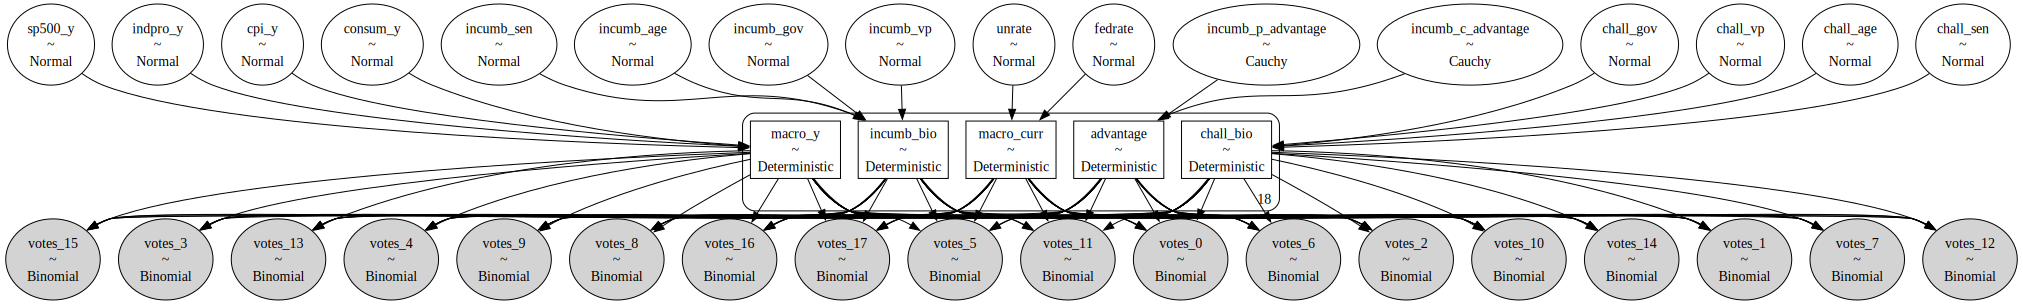

In [279]:
pm.model_to_graphviz(model)

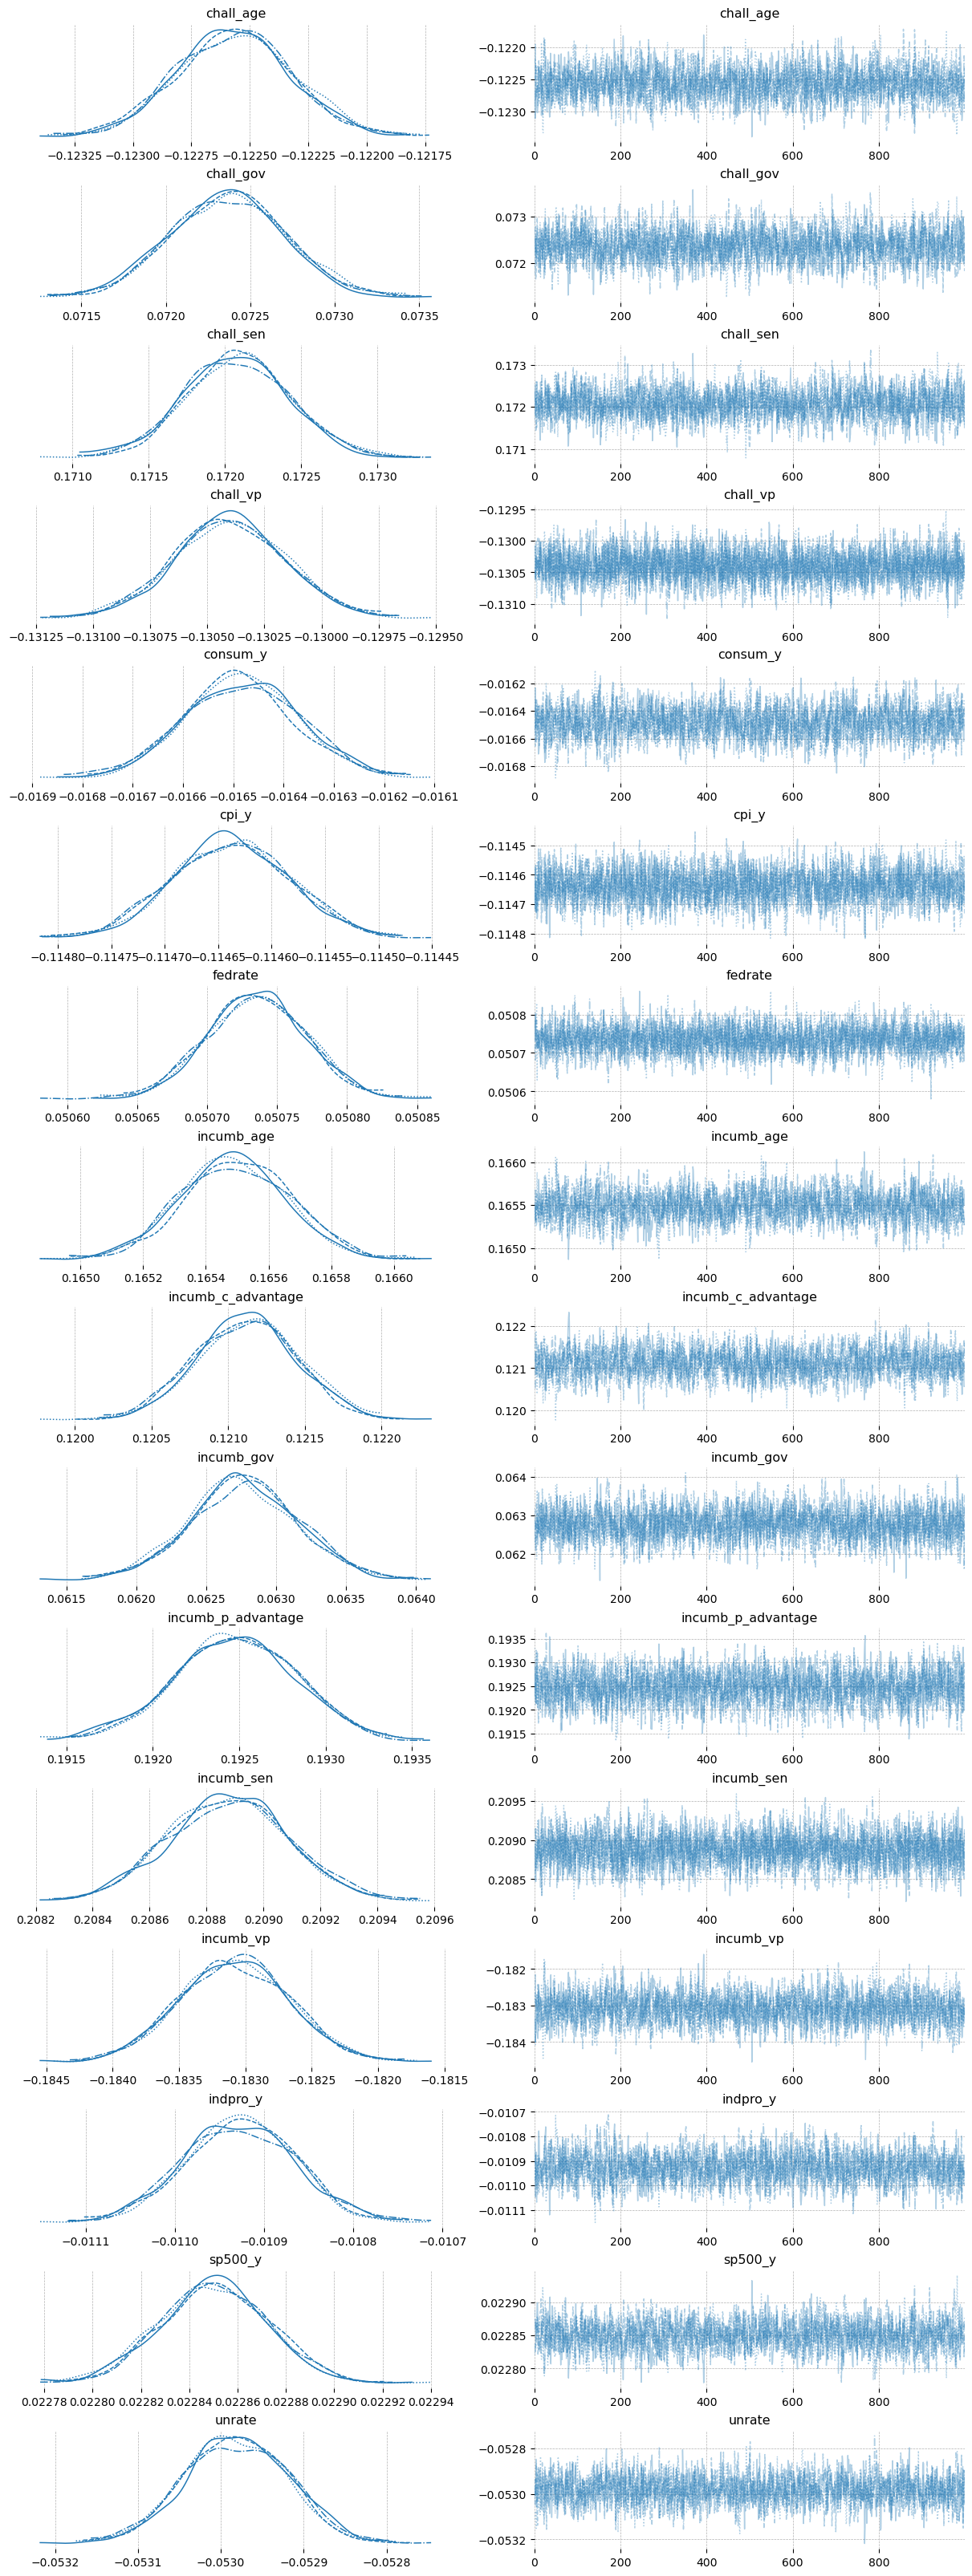

In [270]:
az.plot_trace(idata);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

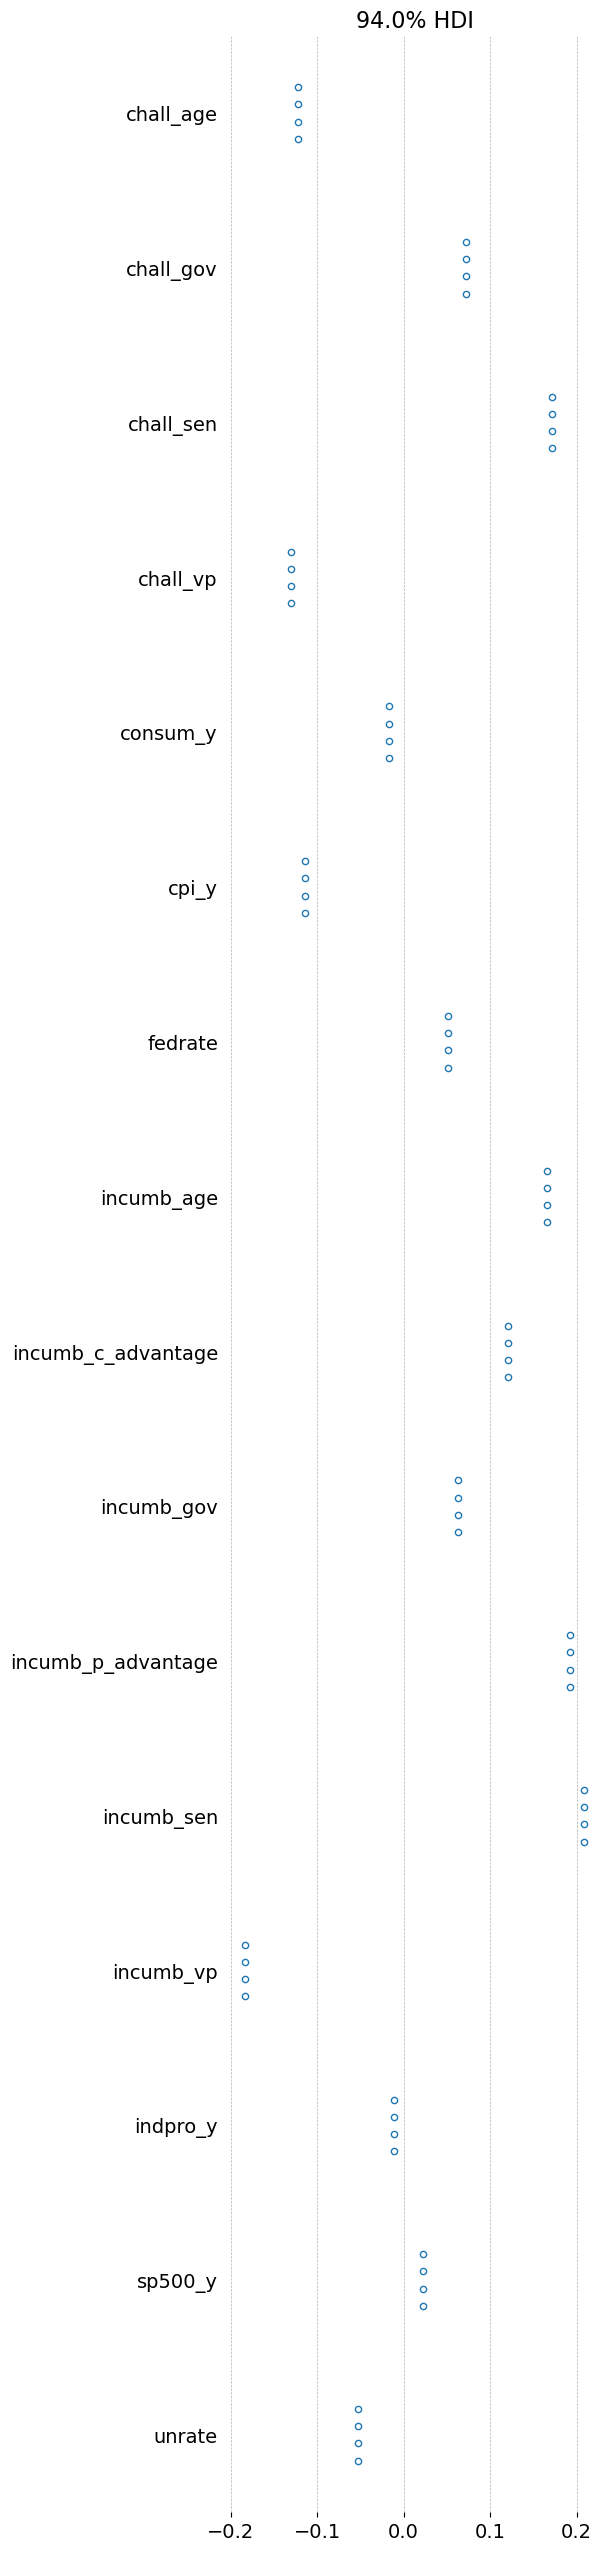

In [271]:
az.plot_forest(idata)

In [272]:
posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data

In [290]:
df_train

,election_id,total_votes,inc_candidate_id,inc_party_id,inc_votes,inc_age,chal_candidate_id,chal_party_id,chal_votes,chal_age,...,prev_cab_i,candidate_id_c,candidate_name_c,birthday_c,party_id_c,prev_vp_c,prev_sen_c,prev_rep_c,prev_gov_c,prev_cab_c
0,president_1948,46170639,truman,d,24179347.0,0.354466,dewey,r,21991292.0,-1.413584,...,0,dewey,Thomas E. Dewey,"Mar 24, 1902",r,0,0,0,1,0
1,president_1952,61450619,stevenson,d,27375090.0,-0.806900,eisenhower,r,34075529.0,0.114230,...,1,eisenhower,Dwight D. Eisenhower,"Oct 14, 1890",r,0,0,0,0,0
2,president_1956,61607208,eisenhower,r,35579180.0,0.510471,stevenson,d,26028028.0,-0.410659,...,0,stevenson,Adlai Stevenson II,1900-02-05,d,0,0,0,0,1
3,president_1960,68329141,nixon,r,34108157.0,-1.293059,kennedy,d,34220984.0,-1.726676,...,0,kennedy,John F. Kennedy,1917-05-29,d,0,1,1,0,0
4,president_1964,70307754,johnson_l,d,43129566.0,-0.466453,goldwater,r,27178188.0,-0.501120,...,0,goldwater,Barry Goldwater,"Jan 2, 1909",r,0,1,0,0,0
5,president_1968,63060646,humphrey,d,31275166.0,-0.341866,nixon,r,31785480.0,-0.502475,...,0,nixon,Richard Nixon,"Jan 9, 1913",r,1,1,1,0,0
6,president_1972,76341932,nixon,r,47168710.0,-0.106234,mcgovern,d,29173222.0,-1.048219,...,0,mcgovern,George McGovern,1922-07-19,d,0,1,1,0,0
7,president_1976,79980515,ford,r,39148634.0,0.237734,carter,d,40831881.0,-0.871902,...,0,carter,Jimmy Carter,1924-10-01,d,0,0,0,1,0
8,president_1980,79383345,carter,d,35480115.0,-0.475661,reagan,r,43903230.0,0.874752,...,0,reagan,Ronald Reagan,"Feb 6, 1911",r,0,0,0,1,0
9,president_1984,92032824,reagan,r,54455472.0,1.270992,mondale,d,37577352.0,-0.401993,...,0,mondale,Walter Mondale,1928-01-05,d,1,1,0,0,0
